## Data Loading

In [1]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

filename = 'data.mat'

mat_file = io.loadmat(filename)
print(mat_file.keys())

dict_keys(['__header__', '__version__', '__globals__', 'non_target_data', 'srate', 'target_data'])


In [2]:
target_data = mat_file['target_data']
non_target_data = mat_file['non_target_data']
srate = np.squeeze(mat_file['srate'])

print("Target data shape: ", target_data.shape)
print("Non-target data shape: ", non_target_data.shape)
print("Sampling rate: ", srate)

Target data shape:  (32, 75, 2662)
Non-target data shape:  (32, 300, 2662)
Sampling rate:  2048


데이터는 32채널로 이루어져 있고, Target은 75개, Non-target은 300개의 Trial이 있습니다.

1초에 2048개의 data point가 있고, -0.3초 ~ +1.0초 사이의 데이터입니다.

![Cap_image](./Images/cap_32_layout_medium.jpg)

뇌파가 어떻게 생겼는지 보기 위한 함수를 만들어줍니다.

In [3]:
def draw_EEG(target, non_target, channel, is_mean=False):
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)

    xticks = np.linspace(-300, 1000, target.shape[-1])
    plotted_target_data = []
    plotted_non_target_data = []
    if is_mean:
        plotted_target_data = np.mean(target[channel, :, :], axis=0)
        ax1.plot(xticks, plotted_target_data)
    else:
        plotted_target_data = target[channel, :, :]
        for trial in range(target.shape[1]):
            ax1.plot(xticks, target[channel, trial, :])

    if is_mean:
        plotted_non_target_data = np.mean(non_target[channel, :, :], axis=0)
        ax2.plot(xticks, plotted_non_target_data)
    else:
        plotted_non_target_data = non_target[channel, :, :]
        for trial in range(non_target.shape[1]):
            ax2.plot(xticks, non_target[channel, trial, :])

    ylim = (np.min([np.min(plotted_target_data), np.min(plotted_non_target_data)]) - 1,
            np.max([np.max(plotted_target_data), np.max(plotted_non_target_data)]) + 1)
    ax1.set_title('Target EEG')
    ax1.set_xticks(np.linspace(-300, 1000, 14))
    ax1.set_ylim(ylim)
    ax2.set_title('Non-target EEG')
    ax2.set_xticks(np.linspace(-300, 1000, 14))
    ax2.set_ylim(ylim)

    plt.show()

def draw_heatmap(data, title=None):
    plt.figure(figsize=(20, 5))
    plt.pcolor(data, cmap=plt.cm.rainbow, vmin=-5, vmax=5)
    plt.xticks(np.linspace(0, data.shape[-1], 14), np.linspace(-300, 1000, 14).astype('int'))
    plt.colorbar()
    if title:
        plt.title(title)
    plt.show()

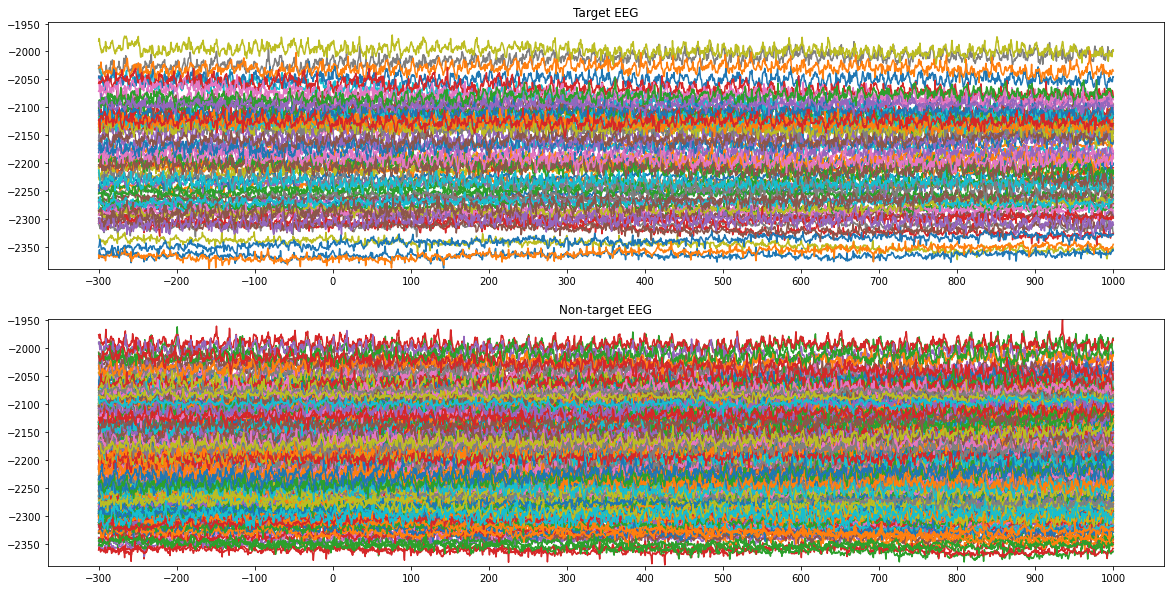

In [4]:
draw_EEG(target_data, non_target_data, 31)

## Preprocessing

**CAR**

Axis 0번(Channel axis)의 평균을 모든 신호에 대해서 제거합니다. 움직임이나 심장 박동 등 모든 채널에서 공통된 잡신호가 제거됩니다.

In [5]:
target_data = target_data - np.mean(target_data, axis=0)
non_target_data = non_target_data - np.mean(non_target_data, axis=0)

**Baseline Correction**

각 채널별로 -0.3s ~ 0s의 평균을 모든 신호에 대해 빼줍니다. 신호를 0V 기준으로 정렬하게 됩니다.

In [6]:
baseline_target = np.mean(target_data[:, :, 0:int(srate * 0.3)], axis=2)
baseline_non_target = np.mean(non_target_data[:, :, 0:int(srate * 0.3)], axis=2)

target_data = target_data - np.expand_dims(baseline_target, axis=-1)
non_target_data = non_target_data - np.expand_dims(baseline_non_target, axis=-1)

**Bandpass Filtering** (1 ~ 30 Hz)

P300을 관측하기 위해 1 ~ 30Hz의 신호만을 추출합니다.

In [7]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

for channel in range(target_data.shape[0]):
    for trial in range(target_data.shape[1]):
        target_data[channel, trial, :] = butter_bandpass_filter(target_data[channel, trial, :], 1, 30, srate, 3)

for channel in range(non_target_data.shape[0]):
    for trial in range(non_target_data.shape[1]):
        non_target_data[channel, trial, :] = butter_bandpass_filter(non_target_data[channel, trial, :], 1, 30, srate, 3)

모든 과정을 거친 후에, 우리가 원하는 뇌파가 되었는지 확인할 수 있습니다.

아래 그림은 Cz 채널에 대한 뇌파입니다.

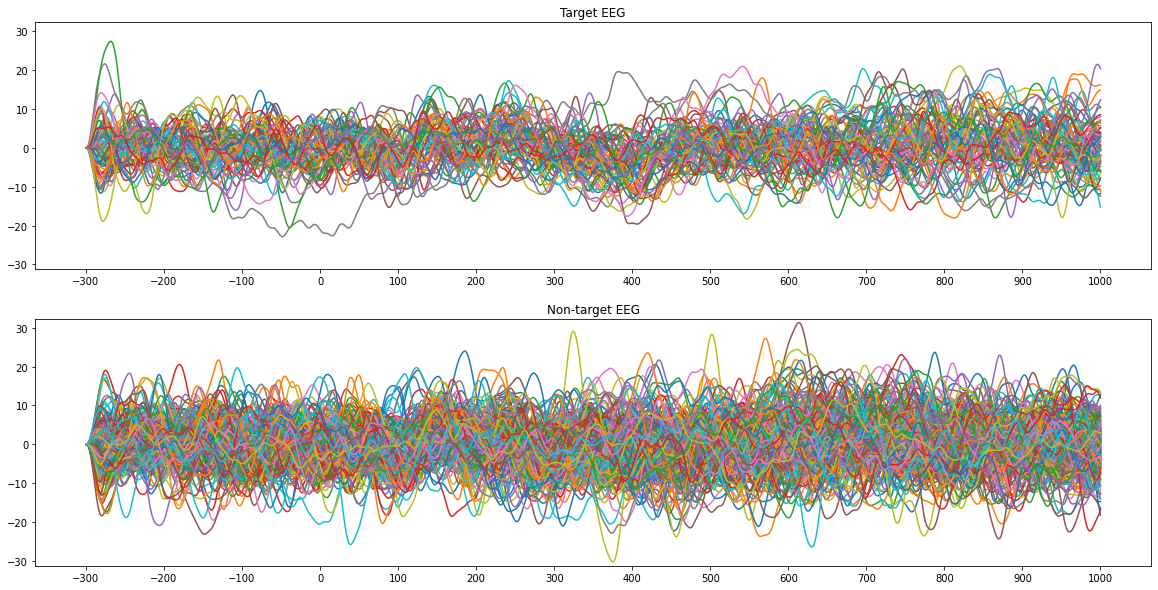

In [8]:
draw_EEG(target_data, non_target_data, 31)

위 뇌파는 모든 Trial에 대하여 Cz 채널만 그려본 것입니다. 아래는 위 뇌파를 모두 평균낸 그림입니다.

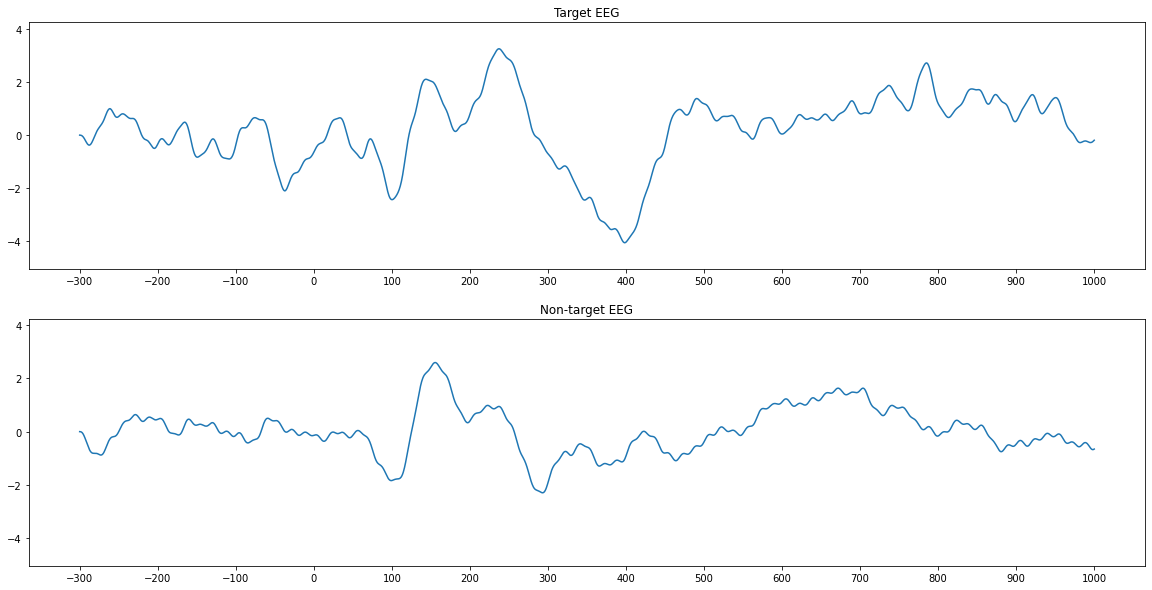

In [9]:
draw_EEG(target_data, non_target_data, 31, True)

우리가 분류하고자 하는 데이터는 위 그림과 같습니다. 위 그림에서 Target은 300ms 부근에 peak가 있고, 아래 그림에서는 300ms 부근에 peak가 없습니다. 이처럼, 특정한 (의미있는) 자극이 주어졌을 때 300ms 부근에서 Peak가 발생하는 것을 P300 또는 P3라고 하며, 이것을 찾아내는 분류기를 만들어 볼 예정입니다.

**Downsampling**

머신러닝에 이용하기 위해 차원을 축소합니다. 여기서는 32 Channel x 32 time을 사용합니다.

In [10]:
resample_target_data = np.zeros(target_data.shape[:-1] + (32,))
resample_non_target_data = np.zeros(non_target_data.shape[:-1] + (32,))

tick = target_data.shape[-1] // 32
for i in range(32):
    tick_start, tick_end = i * tick, (i+1) * tick - 1 if i != 31 else target_data.shape[-1]
    resample_target_data[:, :, i] = np.mean(target_data[:, :, tick_start:tick_end], axis=2)

tick = non_target_data.shape[-1] // 32
for i in range(32):
    tick_start, tick_end = i * tick, (i+1) * tick - 1 if i != 31 else non_target_data.shape[-1]
    resample_non_target_data[:, :, i] = np.mean(non_target_data[:, :, tick_start:tick_end], axis=2)

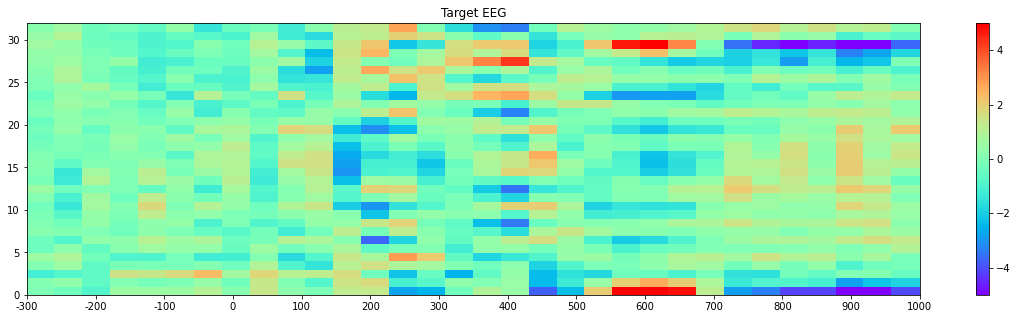

In [11]:
draw_heatmap(np.mean(resample_target_data, axis=1), title='Target EEG')

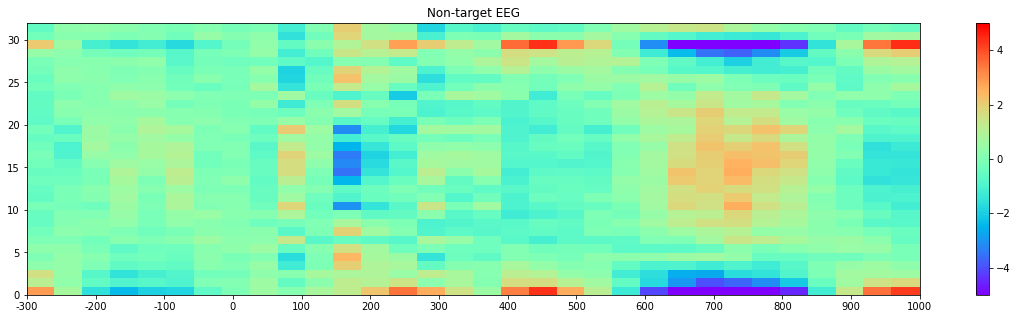

In [12]:
draw_heatmap(np.mean(resample_non_target_data, axis=1), title='Non-target EEG')

## Save data

Downsampling한 데이터를 추후에 사용할 수 있도록 데이터를 저장합니다.

데이터가 (Channel, Trial, Time)으로 이루어져 있는데, 추후 학습에 쉽게 사용될 수 있도록 (Trial, Channel, Time)으로 변경하여 저장합니다.

In [13]:
resample_target_data = np.transpose(resample_target_data, [1, 0, 2])
resample_non_target_data = np.transpose(resample_non_target_data, [1, 0, 2])

output_file = "./resampled_data.npz"
np.savez(output_file, target_data=resample_target_data, non_target_data=resample_non_target_data)